# Extratropical Temperature Quantile Theory
This notebook looks at trying to recreate the black lines of Figure 2 of Byrne 2021. I.e. it tries to estimate the temperature above a given quantile, given details of the average summer day of that climate in the extratropics.

It looks at the difference between the $\kappa=2$ and $\kappa=1$ simulations because both of these simulations are convectively neutral on the hottest and average summer days in the extratropics.


In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-01-18 16:25:31,395 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [14]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_quant`, for extratropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [5]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
region = 'Extratropics'
lat_min = 30
lat_max = 60

temp_summer_av = np.zeros(n_exp)
ds_summer = []
for i in tqdm(range(n_exp)):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
    ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
    # Combine hemispheres and average over longitude, time and latitude.
    ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
    ds_summer += [ds_use]
    ds_summer[i].load()     # Load in averaged dataset so later computation and conversion to numpy is much quicker
    temp_summer_av[i] = ds_summer[i].temp[-1]

100%|██████████| 2/2 [00:24<00:00, 12.28s/it]


In [23]:
# Get data set averaged over all days exceeding every quantile of near surface temperature in extratropics.
# Do this for each optical depth value and each quantile
quantiles_all = np.arange(90, 100)
n_quantiles = len(quantiles_all)
temp_local_mean = np.zeros(n_exp)
temp_all_quant = np.zeros((n_exp, n_quantiles))
sphum_all_quant = np.zeros((n_exp, n_quantiles))
ds_quant = [[], []]
for i in range(n_exp):
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
    # Collapse to single coordinate and then take quantile over it
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    temp_local_mean[i] = ds_use.temp[-1].mean(dim='lon_lat_time').to_numpy()
    for j in tqdm(range(n_quantiles)):
        quantile_thresh = ds_use.temp[-1].quantile(quantiles_all[j]/100, dim='lon_lat_time', keep_attrs=True)
        # Average each variable in data over days where near surface temperature exceeds this quantile
        ds_use2 = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
        ds_quant[i] += [ds_use2]
        ds_quant[i][j].load()  # Load in averaged dataset so later computation and conversion to numpy is much quicker

        # Record mean extratropical near surface temperature
        temp_all_quant[i, j] = ds_quant[i][j].temp[-1]

100%|██████████| 10/10 [04:11<00:00, 25.18s/it]


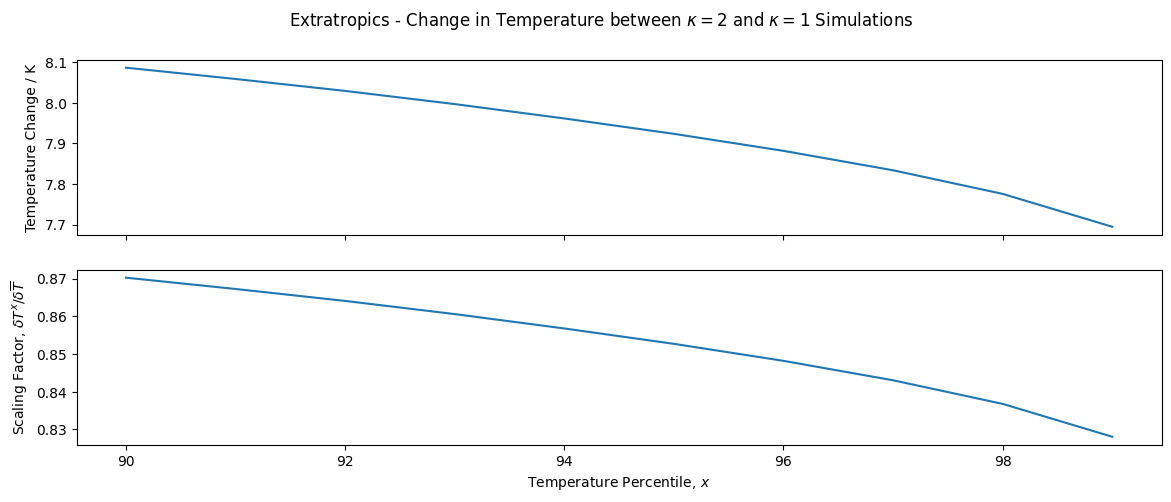

In [31]:
# In second plot here, normalise by change in the summer mean temperature
fig, ax = plt.subplots(2,1, figsize=(14, 5), sharex=True)
ax[0].plot(quantiles_all, temp_all_quant[1]-temp_all_quant[0])
ax[0].set_ylabel('Temperature Change / K')
ax[1].plot(quantiles_all, (temp_all_quant[1]-temp_all_quant[0])/(temp_summer_av[1] - temp_summer_av[0]))
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
ax[1].set_xlabel('Temperature Percentile, $x$')
plt.suptitle(f"{region} - Change in Temperature between $\kappa={tau_lw_warm}$ and $\kappa={tau_lw_ref}$ Simulations");

## Theory for Temperature Change, $\delta T_x$ of days exceeding percentile $x$

In [65]:
p_total = float(ds_summer[0].phalf[-1]) * 100  # total atmospheric pressure

def moving_average(x, w):
    # Takes average over w consecutive values in x
    return np.convolve(x, np.ones(w), 'valid') / w

def sphum_sat(temp):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), p_total)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor(temp):
    # Alpha in byrne 2021
    return L_v / (R_v * temp**2)

# Get the average temperature between experiments for computing some of the parameters below
temp_mean_mid = np.mean(temp_summer_av)             # mean refers to summer mean
temp_quant_mid = np.mean(temp_all_quant, axis=0)

In [108]:
# Compute constants required for theory
alpha_quant = clausius_clapeyron_factor(temp_quant_mid)
alpha_mean = clausius_clapeyron_factor(temp_mean_mid)
q_quant = np.asarray([np.asarray([ds_quant[i][j].sphum[-1] for j in range(n_quantiles)]) for i in range(n_exp)])
q_quant_mid = np.mean(q_quant, axis=0)
q_mean = np.asarray([ds_summer[i].sphum[-1] for i in range(n_exp)])
q_mean_mid = np.mean(q_mean)
rh_quant = rh_from_sphum(q_quant,temp_all_quant,p_total)/100
rh_mean = rh_from_sphum(q_mean,temp_summer_av,p_total)/100

q_sat_quant = sphum_sat(temp_quant_mid)
q_sat_mean = sphum_sat(temp_mean_mid)

epsilon_constant = (L_v * alpha_quant * q_sat_quant) / (c_p + L_v * alpha_quant * q_quant_mid)
delta_rh_quant = rh_quant[1] - rh_quant[0]
prefactor = 1/(1+epsilon_constant * delta_rh_quant)      # prefactor is 1 if RH is constant between k=2 and k=1 experiments

gamma_t = (c_p + L_v * alpha_mean * q_mean_mid) / (c_p + L_v * alpha_quant * q_quant_mid)
# not sure about this, seems to be factor of 100 out - maybe due to definition of relative humidity
gamma_r = (L_v * q_sat_mean) / (c_p + L_v * alpha_quant * q_quant_mid)
gamma_nl = alpha_mean * gamma_r
gamma_r_quant = -epsilon_constant/alpha_quant

delta_t_mean = temp_summer_av[1] - temp_summer_av[0]
delta_rh_mean = rh_mean[1] - rh_mean[0]

In [125]:
# Need to add the delta h* term, and can probably ignore the non linear term
prefactor * (gamma_t*delta_t_mean + gamma_r * delta_rh_mean + gamma_r_quant * delta_rh_quant + gamma_nl * delta_rh_mean * delta_t_mean)

array([7.56848596, 7.52224444, 7.47591152, 7.42840974, 7.38070566,
       7.33394002, 7.28603847, 7.23362203, 7.17369972, 7.09331876])

In [121]:
temp_all_quant[1]-temp_all_quant[0]

array([8.08673096, 8.05889893, 8.02947998, 7.99703979, 7.9616394 ,
       7.92376709, 7.88186646, 7.83398438, 7.77584839, 7.69485474])